In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (142 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [ ]:
import random
import cv2
import shutil

# Get to know the data

In this section, I will download the same example tumor_091 as that in the starter code, trying to know more about data.

## Download the example

In [ ]:
slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0   139M      0  0:00:03  0:00:03 --:--:--  139M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  55.1M      0 --:--:-- --:--:-- --:--:-- 54.9M


## Sanity check

Here I tried to know more about the data and do a basci sanity check to see whether downsampling works as expecte

In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


## Show mask and slides with different zoom level

In [ ]:
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
# Note: (x,y) here refer to the center of the reion
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

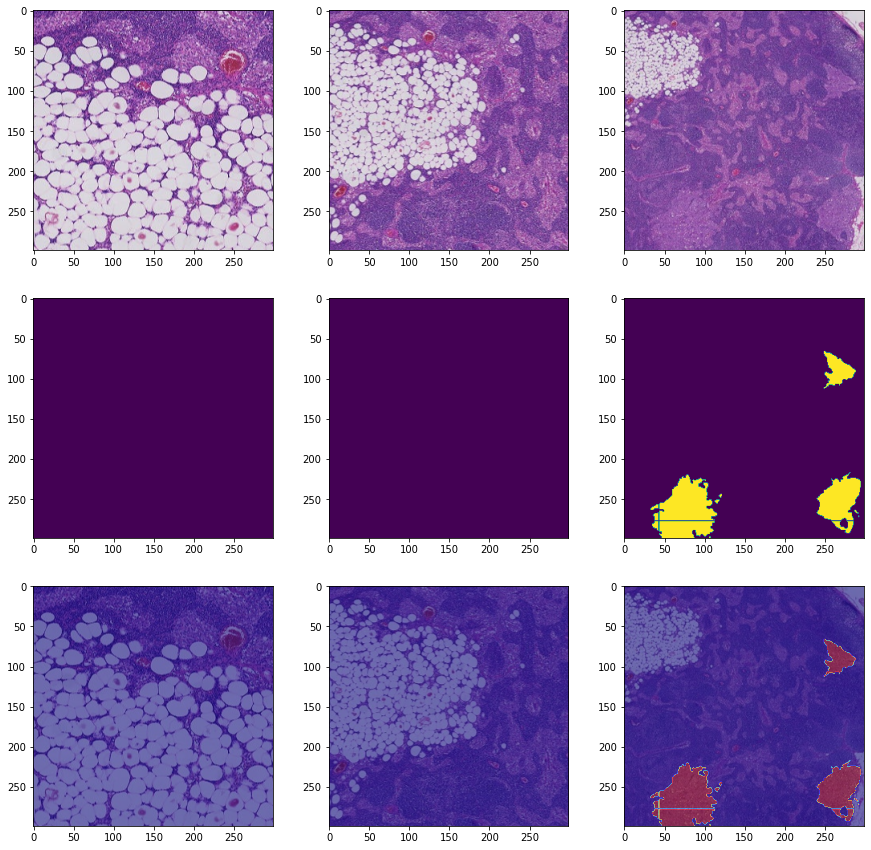

In [ ]:
x_axis = 30000
y_axis = 15000
fig, axs = plt.subplots(3, 3,figsize=(15,15))
for i in range(3):
  slide_image = read_slide(slide, x=x_axis, y=y_axis, level=4+i, width=299, height=299)
  axs[0,i].imshow(slide_image)
  mask_image = read_slide(tumor_mask, x=x_axis, y=y_axis, level=4+i, width=299, height=299)
  mask_image = mask_image[:,:,0]
  axs[1,i].imshow(mask_image)
  axs[2,i].imshow(slide_image)
  axs[2,i].imshow(mask_image, cmap='jet', alpha=0.5)
  #print(find_percentage_tissue_pixels(slide_image))

# Create dataset

Here I tried to got the train and validation dataset as well as do some basic balancing.

Based on what I would do in model building, every sample is 299*299. I also got the sample in different zoom levels. And only  patches with more than 50% percent non-tissue areas will be kept.

## Ignore non-tissue area

85702 tissue_pixels pixels (95.9 percent of the image)


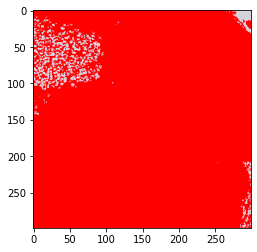

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))


tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [ ]:
# Define a function to judege the percent of tissue areas in the slides
def find_percentage_tissue_pixels(image,width=150,height=150,intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    result = list(zip(indices[0], indices[1]))
    percentage = len(result) / float(width * height) * 100
    return percentage

## Get the label for samples. 

If the patch contains one area tagged 1.0, I will set the label for the whole patch to be 1.0. Otherwise, the sample will be tagged as 0.0


In [ ]:
def define_img_label(image):
  total = sum(sum(image))
  if total.any() > 0:
    return 1.0
  else:
    return 0.0

## Create dataset with only one zoom level

### Read images and create original dataset

In [ ]:
slide_path = '/content/drive/MyDrive/tumor_101.tif'
slide = open_slide(slide_path)

tumor_mask_path = '/content/drive/MyDrive/tumor_101_mask.tif'
tumor_mask = open_slide(tumor_mask_path)

In [ ]:
x_range = 60000
y_range = 50000
width = 150
height = 150
MAX_SIZE = 10000
levels = 2
count = 0
label_true = []
label_false = []
while(count<MAX_SIZE):
  x_axis = random.randint(0,x_range)
  y_axis = random.randint(0,y_range)
  slide_image = read_slide(slide, x=x_axis, y=y_axis,level=levels, width=150, height=150)
  #plt.imshow(slide_image)
  #plt.show()
  if find_percentage_tissue_pixels(slide_image) >= 0.5:
    mask_image = read_slide(tumor_mask, x=x_axis, y=y_axis, level=levels, width=150, height=150)
    mask_image = mask_image[:,:,0]
    if define_img_label(mask_image):
      label_true.append(((levels,x_axis,y_axis),define_img_label(mask_image)))
    else:
      label_false.append(((levels,x_axis,y_axis),define_img_label(mask_image)))
    #plt.imshow(mask_image)
    count = count+1

### Sanity check and balance the trainning dataset

It is obvious that there will be much more slide patches with no cancerous cells. In this section, we will examine the percentage of two labels and try to balance the data.

In [ ]:
# see the percentage of 1.0
print("There are %d samples with cancerous cells, taking %.2f percent. "%(len(label_true),
                                                                           len(label_true)/MAX_SIZE*100))
print("There are %d samples with cancerous cells, taking %.2f percent. "%(len(label_false),
                                                                           len(label_false)/MAX_SIZE*100))

There are 0 samples with cancerous cells, taking 0.00 percent. 
There are 10000 samples with cancerous cells, taking 100.00 percent. 


I will keep all the samples with cancerous cell, but randomly choose some sample without cancerous cells to make the whoe dataset balanced.

In [ ]:
TIMES = 2
random.shuffle(label_false)
label_false = label_false[0:len(label_true)*TIMES]
train_df = [] #final balanced train_dataset
train_df.extend(label_false)
train_df.extend(label_true)

In [ ]:
label_true_train = label_true[0:int(len(label_true)*0.8)]
label_true_val = label_true[int(len(label_true)*0.8):]
label_false_train = label_false[0:int(len(label_false)*0.8)]
label_false_val = label_false[int(len(label_false)*0.8):]

In [ ]:
print(len(label_true_train))
print(len(label_true_val))
print(len(label_false_train))
print(len(label_false_val))

263
66
526
132


In [ ]:
seq = str('064')

In [ ]:
for i in range(len(label_true_train)):
  tmp = label_true_train[i]
  levels,x_axis,y_axis,label = tmp[0][0],tmp[0][1],tmp[0][2],tmp[1]
  slide_image = read_slide(slide, x=x_axis, y=y_axis,level=levels, width=150, height=150)
  name = str(seq)+'_'+str(levels)+'_'+str(i)+'_'+str(label)+'.jpg'
  path = '/content/test/train/with/'+name
  cv2.imwrite(path,slide_image)

In [ ]:
for i in range(len(label_true_val)):
  tmp = label_true_val[i]
  levels,x_axis,y_axis,label = tmp[0][0],tmp[0][1],tmp[0][2],tmp[1]
  slide_image = read_slide(slide, x=x_axis, y=y_axis,level=levels, width=150, height=150)
  name = str(seq)+'_'+str(levels)+'_'+str(i)+'_'+str(label)+'.jpg'
  path = '/content/test/validation/with/'+name
  cv2.imwrite(path,slide_image)

In [ ]:
for i in range(len(label_false_train)):
  tmp = label_false_train[i]
  levels,x_axis,y_axis,label = tmp[0][0],tmp[0][1],tmp[0][2],tmp[1]
  slide_image = read_slide(slide, x=x_axis, y=y_axis,level=levels, width=150, height=150)
  name = str(seq)+'_'+str(levels)+'_'+str(i)+'_'+str(label)+'.jpg'
  path = '/content/test/train/without/'+name
  cv2.imwrite(path,slide_image)

In [ ]:
for i in range(len(label_false_val)):
  tmp = label_false_val[i]
  levels,x_axis,y_axis,label = tmp[0][0],tmp[0][1],tmp[0][2],tmp[1]
  slide_image = read_slide(slide, x=x_axis, y=y_axis,level=levels, width=150, height=150)
  name = str(seq)+'_'+str(levels)+'_'+str(i)+'_'+str(label)+'.jpg'
  path = '/content/test/validation/without/'+name
  cv2.imwrite(path,slide_image)

In [ ]:
shutil.make_archive('test', 'zip', "/content/test/")

'/content/test.zip'

## Create dataset with different zoom levels

### Read images and create original dataset

In [ ]:
train_df = [] #final balanced train_dataset

In [ ]:
final_write = [] 

In [ ]:
slide_path = '/content/drive/MyDrive/tumor_101.tif'
slide = open_slide(slide_path)

tumor_mask_path = '/content/drive/MyDrive/tumor_101_mask.tif'
tumor_mask = open_slide(tumor_mask_path)

In [ ]:
seq = str('101')

In [ ]:
x_range = 60000
y_range = 50000
width = 150
height = 150
MAX_SIZE = 2000
levels = 2
count = 0
label_true = []
label_false = []
while(count<MAX_SIZE):
  x_axis = random.randint(0,x_range)
  y_axis = random.randint(0,y_range)
  slide_image = read_slide(slide, x=x_axis, y=y_axis,level=levels, width=150, height=150)
  #plt.imshow(slide_image)
  #plt.show()
  if find_percentage_tissue_pixels(slide_image) >= 0.5:
    mask_image = read_slide(tumor_mask, x=x_axis, y=y_axis, level=levels, width=150, height=150)
    mask_image = mask_image[:,:,0]
    if define_img_label(mask_image):
      label_true.append(((levels,x_axis,y_axis),define_img_label(mask_image)))
    else:
      label_false.append(((levels,x_axis,y_axis),define_img_label(mask_image)))
    #plt.imshow(mask_image)
    count = count+1

### Sanity check and balance the training dataset

In [ ]:
# see the percentage of 1.0
print("There are %d samples with cancerous cells, taking %.2f percent. "%(len(label_true),
                                                                           len(label_true)/MAX_SIZE*100))
print("There are %d samples with cancerous cells, taking %.2f percent. "%(len(label_false),
                                                                           len(label_false)/MAX_SIZE*100))

There are 553 samples with cancerous cells, taking 5.53 percent. 
There are 9447 samples with cancerous cells, taking 94.47 percent. 


In [ ]:
TIMES = 2
random.shuffle(label_false)
label_false = label_false[0:len(label_true)*TIMES]
train_df.extend(label_false)
train_df.extend(label_true)

In [ ]:
for i in range(len(label_false)):
  tmp = label_false[i]
  x_axis,y_axis,label_2 = tmp[0][1],tmp[0][2],tmp[1]
  slide_image_2 = read_slide(slide, x=x_axis, y=y_axis,level=2, width=150, height=150)
  slide_image_3 = read_slide(slide, x=x_axis-525, y=y_axis-225,level=3, width=150, height=150)
  mask_image = read_slide(tumor_mask, x=x_axis-525, y=y_axis-225, level=3, width=150, height=150)
  label_3 = define_img_label(mask_image)
  name_2 = str(seq)+'_'+str('2')+'_'+str(i)+'_'+str(label_2)+'.jpg'
  name_3 = str(seq)+'_'+str('3')+'_'+str(i)+'_'+str(label_3)+'.jpg'
  tmp_list = [name_2,label_2,name_3,label_3]
  final_write.append(tmp_list)
  path_2 = '/content/different/'+name_2
  cv2.imwrite(path_2,slide_image_2)
  path_3 = '/content/different/'+name_3
  cv2.imwrite(path_3,slide_image_3)

In [ ]:
for i in range(len(label_true)):
  tmp = label_true[i]
  x_axis,y_axis,label_2 = tmp[0][1],tmp[0][2],tmp[1]
  slide_image_2 = read_slide(slide, x=x_axis, y=y_axis,level=2, width=150, height=150)
  slide_image_3 = read_slide(slide, x=x_axis-525, y=y_axis-225,level=3, width=150, height=150)
  mask_image = read_slide(tumor_mask, x=x_axis-525, y=y_axis-225, level=3, width=150, height=150)
  label_3 = define_img_label(mask_image)
  name_2 = str(seq)+'_'+str('2')+'_'+str(i)+'_'+str(label_2)+'.jpg'
  name_3 = str(seq)+'_'+str('3')+'_'+str(i)+'_'+str(label_3)+'.jpg'
  tmp_list = [name_2,label_2,name_3,label_3]
  final_write.append(tmp_list)
  path_2 = '/content/different/'+name_2
  cv2.imwrite(path_2,slide_image_2)
  path_3 = '/content/different/'+name_3
  cv2.imwrite(path_3,slide_image_3)

### Sanity check

According to the definition, it is obvious that if the sample contains cancerous cells under zoom level2, it must contain cancerous cells under zoom level3.

In [ ]:
for item in final_write:
  if item[1] == 1.0 and item[3] == 0.0:
    print(item)

In [ ]:
for item in final_write:
  if item[1] == 0.0 and item[3] == 1.0:
    print(item)
    break

['075_2_160_0.0.jpg', 0.0, '075_3_160_1.0.jpg', 1.0]


### Zip the dataset and save the paths in a csv file

In [ ]:
shutil.make_archive('different', 'zip', "/content/different/")

'/content/different.zip'

In [ ]:
from pandas import DataFrame
df = DataFrame (final_write,columns=['zoom_level_2','tag_2','zoom_level_3','tag_3'])
df.to_csv('/content/different.csv')